# 1. Preparation

## 1.1. Import Libraries

In [81]:
import os
import re
import string
import warnings

import lightgbm as lgb
import nltk
import numpy as np
import optuna
import pandas as pd
import tensorflow as tf
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from optuna.integration import KerasPruningCallback
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as tts
from sklearn.utils.class_weight import compute_class_weight as ccw
from tensorflow.keras import Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    BatchNormalization,
    Dense,
    Dropout,
    Flatten,
    Input,
    LeakyReLU,
    Rescaling,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import set_random_seed, to_categorical

pd.options.display.max_columns=100
nltk.download('stopwords')
warnings.simplefilter("ignore")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1.2. Fetching Data

In [82]:
seed = 0
np.random.seed(seed)
set_random_seed(seed)

train_df = pd.read_csv("../input/train.csv", index_col="text_id")
X_train = train_df.full_text
cols = [col for col in train_df.columns if col != "full_text"]
y_train = train_df[cols]
X_test = pd.read_csv("../input/test.csv", index_col="text_id").full_text
X_test_idx = X_test.index

## 1.3. TFIDF Encodings with PCA

In [83]:
def encodingX(X_train = X_train, X_test = X_test, n_components = 500):
    train_idx = X_train.index
    test_idx = X_test.index

    X_train = X_train.str.lower().replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
    X_test = X_test.str.lower().replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
    
    stop_words = stopwords.words('english')
    remove_stopwords = lambda ls: [" ".join([word for word in l.split() if not word in stop_words]) for l in ls] 
    X_train = remove_stopwords(X_train)
    X_test = remove_stopwords(X_test)

    X_train = [re.sub("[%s]" % re.escape(string.punctuation), "", t) for t in X_train]
    X_test = [re.sub("[%s]" % re.escape(string.punctuation), "", t) for t in X_test]
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_matrix(X_train, "tfidf")
    X_test = tokenizer.texts_to_matrix(X_test, "tfidf")

    pca = PCA(n_components=n_components, whiten=True, random_state=seed)
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=train_idx)
    X_test = pd.DataFrame(pca.transform(X_test), index=test_idx)
    return X_train, X_test

def lgb_dataset(X_train, y_train, X_val, y_val):
    lgb_trains = {}
    lgb_vals = {}
    for col in cols:
        exec(f"lgb_trains['{col}'] = lgb.Dataset(X_train, y_train.{col})")
        exec(f"lgb_vals['{col}'] = lgb.Dataset(X_val, y_val.{col})")
    return lgb_trains, lgb_vals

# 2. Building Models

### 2.0.1 Custom Functions

In [96]:
@tf.autograph.experimental.do_not_convert
def MCRMSE_keras(y_true, y_pred):
    return tf.reduce_mean(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))

def building_keras_model(X_train, y_train, params, X_val = None, y_val = None):
    model = Sequential()

    for i in range(1, params["NLayers"]+1):
        if params[f"BatchNorm_l{i}"]:
            model.add(BatchNormalization())
        if params[f"Activation_l{i}"] == "lrelu":
            params[f"Activation_l{i}"] = LeakyReLU(alpha=.1)
        
        if i == 1:
            model.add(Dense(params[f"Units_l{i}"], input_dim=X_train.shape[1], activation=params[f"Activation_l{i}"]))
        else:
            model.add(Dense(params[f"Units_l{i}"], activation=params[f"Activation_l{i}"]))
            
        if params[f"Dropout_l{i}"]:
            model.add(Dropout(.3))

    if params["Rescaling"]:
        model.add(Dense(y_train.shape[1], activation="sigmoid"))
        model.add(Rescaling(4, offset=1))
    else:
        model.add(Dense(y_train.shape[1], activation="linear"))
        
    optimizer = optimizers.Adam(learning_rate=params["LearningRate"], amsgrad=True)
    model.compile(loss=MCRMSE_keras, optimizer=optimizer, metrics=[MCRMSE_keras])
    
    callbacks = [EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]
    if not params["Pruner"] is None:
        callbacks += [params["Pruner"]]
    
    model.fit(X_train, y_train, validation_data = (X_val, y_val),
              batch_size=params["BatchSize"], epochs=150,
              workers=8, use_multiprocessing=True, verbose=0, callbacks=callbacks)
    
    if not X_val is None:
        evaluation = model.evaluate(X_val, y_val, verbose=0)
        return model, evaluation
    else:
        return model
    
def optuna_params(trial):
    params = {
        "n_splits": 4,
        "NLayers": trial.suggest_int("NLayers", 7, 20),
        "LearningRate": trial.suggest_uniform("LearningRate", .0005, .01),
        "BatchSize": 2**3,
        'Rescaling': False,#trial.suggest_categorical('Rescaling', [True, False]) 
        "Pruner": None #KerasPruningCallback(trial, "val_acc"),
        }

    for i in range(1, params["NLayers"]+1):
        params[f"BatchNorm_l{i}"] = trial.suggest_categorical(f'BatchNorm_l{i}', [True, False])
        params[f"Units_l{i}"] = int(trial.suggest_uniform(f"Units_l{i}", 300, 2000))
        activation = trial.suggest_categorical(f'Activation_l{i}', ['relu', "lrelu", "softplus", "softsign"])
        if activation == "lrelu":
            activation = LeakyReLU(alpha=.1)
        params[f'Activation_l{i}'] = activation
        params[f'Dropout_l{i}'] = trial.suggest_categorical(f'Dropout_l{i}', [True, False]) 
    return params

def prediction(X_test, model):
    return pd.DataFrame(model.predict(X_test), columns=cols, index=X_test_idx)

def KFolds(X_train, y_train, n_splits = 4):
    mskf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    X_trains = []
    X_vals = []
    y_trains = []
    y_vals = []
    
    for train_idx, val_idx in mskf.split(X_train, y_train):
        X_trains.append(X_train.iloc[train_idx,:])
        X_vals.append(X_train.iloc[val_idx,:])
        y_trains.append(y_train.iloc[train_idx,:])
        y_vals.append(y_train.iloc[val_idx,:])
        
    return X_trains, X_vals, y_trains, y_vals

def validating_and_pred4nextLevel(X_train, y_train, params, n_splits = 4):
    preds = []
    evals = []
    X_trains, X_vals, y_trains, y_vals = KFolds(X_train, y_train, n_splits)
    for X_train, X_val, y_train, y_val in zip(X_trains, X_vals, y_trains, y_vals):
        model, evaluation = building_keras_model(X_train, y_train, params, X_val, y_val)
        evals.append(evaluation)
        preds.append(pd.DataFrame(model.predict(X_val), index=X_val.index, columns=y_val.columns))
    return np.mean(evals), pd.concat(preds, axis=0)

def objective(trial):
    tf.keras.backend.clear_session()
    X_train_enc, X_test_enc = encodingX()
    params = optuna_params(trial)
    evals, preds = validating_and_pred4nextLevel(X_train_enc, y_train, params, params["n_splits"])
    return evals

def study_result(study_name):
    study = optuna.load_study(study_name=study_name, storage=storage)
    bts = []
    for bt in study.best_trials:
        values = bt.values or [0]
        values = [bt.number] + values + [bt.datetime_complete - bt.datetime_start] + list(bt.params.values())
        bts.append(pd.DataFrame([values], columns = ["number", "MCRMSE", "exec_time"] + list(bt.params.keys())))
        res = pd.concat(bts, axis=0, ignore_index=True).sort_values("MCRMSE")
    return res

### 2.0.2 Set the Variables

In [87]:
storage = 'mysql+pymysql://iori:'+os.environ["MySQL_PASSWORD"]+'@'+os.environ["MySQL_IP"]+":3306/kaggleELL?charset=utf8mb4"
directions = ["minimize"]

## 2.1. keras1

In [ ]:
study_name = "keras1"

keras_study = optuna.create_study(study_name=study_name, directions=directions,# pruner=optuna.pruners.MedianPruner(), 
                                  storage=storage, load_if_exists=True)
keras_study.optimize(objective, n_trials=50, gc_after_trial=True)
res = study_result(study_name)
res

In [100]:
res = study_result("keras1")
params = {k:v for k,v in zip(res.columns, res.values[0])} | {"BatchSize": 2**3, "Rescaling": False, "Pruner": None}
X_train_enc, X_test_enc = encodingX()
evals, pred = validating_and_pred4nextLevel(X_train_enc, y_train, params, n_splits = 4)
pred

31/31 [==============================] - 0s 4ms/step


,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
00299B378633,3.082433,3.002577,3.356617,3.219905,3.144602,2.998403
003885A45F42,3.597775,3.517406,3.883855,3.734811,3.678212,3.495819
009BCCC61C2A,3.594927,3.514857,3.881074,3.732047,3.675216,3.493197
00B21F9B726F,2.806245,2.697015,3.063315,2.917543,2.834754,2.707040
00BCADB373EF,3.144325,3.071493,3.423931,3.281448,3.211622,3.063654
...,...,...,...,...,...,...
FF66DA76E15F,3.077936,3.126721,3.154651,3.055489,3.045090,3.192701
FF8BAC351714,2.493648,2.512155,2.598581,2.484934,2.433185,2.566717
FF9C278EA478,3.322350,3.386588,3.349561,3.294065,3.279477,3.428648


In [107]:
pd.concat([y_train[col], pred[col]], axis=1)

,cohesion,cohesion
text_id,,
0016926B079C,3.5,3.125620
0022683E9EA5,2.5,2.897768
00299B378633,3.0,3.082433
003885A45F42,4.5,3.597775
0049B1DF5CCC,2.5,2.861268
...,...,...
FFD29828A873,2.5,2.981773
FFD9A83B0849,4.0,3.560512
FFDC4011AC9C,2.5,2.994234


cohesion 1.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '1.0')

(1.0, 5.0)

Text(0.5, 1.0, 'cohesion1.0')

cohesion 1.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '1.5')

(1.0, 5.0)

Text(0.5, 1.0, 'cohesion1.5')

cohesion 2.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '2.0')

(1.0, 5.0)

Text(0.5, 1.0, 'cohesion2.0')

cohesion 2.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '2.5')

(1.0, 5.0)

Text(0.5, 1.0, 'cohesion2.5')

cohesion 3.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '3.0')

(1.0, 5.0)

Text(0.5, 1.0, 'cohesion3.0')

cohesion 3.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '3.5')

(1.0, 5.0)

Text(0.5, 1.0, 'cohesion3.5')

cohesion 4.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '4.0')

(1.0, 5.0)

Text(0.5, 1.0, 'cohesion4.0')

cohesion 4.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '4.5')

(1.0, 5.0)

Text(0.5, 1.0, 'cohesion4.5')

cohesion 5.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '5.0')

(1.0, 5.0)

Text(0.5, 1.0, 'cohesion5.0')

syntax 1.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '1.0')

(1.0, 5.0)

Text(0.5, 1.0, 'syntax1.0')

syntax 1.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '1.5')

(1.0, 5.0)

Text(0.5, 1.0, 'syntax1.5')

syntax 2.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '2.0')

(1.0, 5.0)

Text(0.5, 1.0, 'syntax2.0')

syntax 2.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '2.5')

(1.0, 5.0)

Text(0.5, 1.0, 'syntax2.5')

syntax 3.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '3.0')

(1.0, 5.0)

Text(0.5, 1.0, 'syntax3.0')

syntax 3.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '3.5')

(1.0, 5.0)

Text(0.5, 1.0, 'syntax3.5')

syntax 4.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '4.0')

(1.0, 5.0)

Text(0.5, 1.0, 'syntax4.0')

syntax 4.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '4.5')

(1.0, 5.0)

Text(0.5, 1.0, 'syntax4.5')

syntax 5.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '5.0')

(1.0, 5.0)

Text(0.5, 1.0, 'syntax5.0')

vocabulary 1.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '1.0')

(1.0, 5.0)

Text(0.5, 1.0, 'vocabulary1.0')

vocabulary 1.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '1.5')

(1.0, 5.0)

Text(0.5, 1.0, 'vocabulary1.5')

vocabulary 2.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '2.0')

(1.0, 5.0)

Text(0.5, 1.0, 'vocabulary2.0')

vocabulary 2.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '2.5')

(1.0, 5.0)

Text(0.5, 1.0, 'vocabulary2.5')

vocabulary 3.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '3.0')

(1.0, 5.0)

Text(0.5, 1.0, 'vocabulary3.0')

vocabulary 3.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '3.5')

(1.0, 5.0)

Text(0.5, 1.0, 'vocabulary3.5')

vocabulary 4.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '4.0')

(1.0, 5.0)

Text(0.5, 1.0, 'vocabulary4.0')

vocabulary 4.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '4.5')

(1.0, 5.0)

Text(0.5, 1.0, 'vocabulary4.5')

vocabulary 5.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '5.0')

(1.0, 5.0)

Text(0.5, 1.0, 'vocabulary5.0')

phraseology 1.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '1.0')

(1.0, 5.0)

Text(0.5, 1.0, 'phraseology1.0')

phraseology 1.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '1.5')

(1.0, 5.0)

Text(0.5, 1.0, 'phraseology1.5')

phraseology 2.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '2.0')

(1.0, 5.0)

Text(0.5, 1.0, 'phraseology2.0')

phraseology 2.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '2.5')

(1.0, 5.0)

Text(0.5, 1.0, 'phraseology2.5')

phraseology 3.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '3.0')

(1.0, 5.0)

Text(0.5, 1.0, 'phraseology3.0')

phraseology 3.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '3.5')

(1.0, 5.0)

Text(0.5, 1.0, 'phraseology3.5')

phraseology 4.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '4.0')

(1.0, 5.0)

Text(0.5, 1.0, 'phraseology4.0')

phraseology 4.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '4.5')

(1.0, 5.0)

Text(0.5, 1.0, 'phraseology4.5')

phraseology 5.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '5.0')

(1.0, 5.0)

Text(0.5, 1.0, 'phraseology5.0')

grammar 1.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '1.0')

(1.0, 5.0)

Text(0.5, 1.0, 'grammar1.0')

grammar 1.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '1.5')

(1.0, 5.0)

Text(0.5, 1.0, 'grammar1.5')

grammar 2.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '2.0')

(1.0, 5.0)

Text(0.5, 1.0, 'grammar2.0')

grammar 2.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '2.5')

(1.0, 5.0)

Text(0.5, 1.0, 'grammar2.5')

grammar 3.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '3.0')

(1.0, 5.0)

Text(0.5, 1.0, 'grammar3.0')

grammar 3.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '3.5')

(1.0, 5.0)

Text(0.5, 1.0, 'grammar3.5')

grammar 4.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '4.0')

(1.0, 5.0)

Text(0.5, 1.0, 'grammar4.0')

grammar 4.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '4.5')

(1.0, 5.0)

Text(0.5, 1.0, 'grammar4.5')

grammar 5.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '5.0')

(1.0, 5.0)

Text(0.5, 1.0, 'grammar5.0')

conventions 1.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '1.0')

(1.0, 5.0)

Text(0.5, 1.0, 'conventions1.0')

conventions 1.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '1.5')

(1.0, 5.0)

Text(0.5, 1.0, 'conventions1.5')

conventions 2.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '2.0')

(1.0, 5.0)

Text(0.5, 1.0, 'conventions2.0')

conventions 2.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '2.5')

(1.0, 5.0)

Text(0.5, 1.0, 'conventions2.5')

conventions 3.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '3.0')

(1.0, 5.0)

Text(0.5, 1.0, 'conventions3.0')

conventions 3.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '3.5')

(1.0, 5.0)

Text(0.5, 1.0, 'conventions3.5')

conventions 4.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '4.0')

(1.0, 5.0)

Text(0.5, 1.0, 'conventions4.0')

conventions 4.5


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '4.5')

(1.0, 5.0)

Text(0.5, 1.0, 'conventions4.5')

conventions 5.0


<AxesSubplot: xlabel='pred'>

Text(0.5, 0, '5.0')

(1.0, 5.0)

Text(0.5, 1.0, 'conventions5.0')

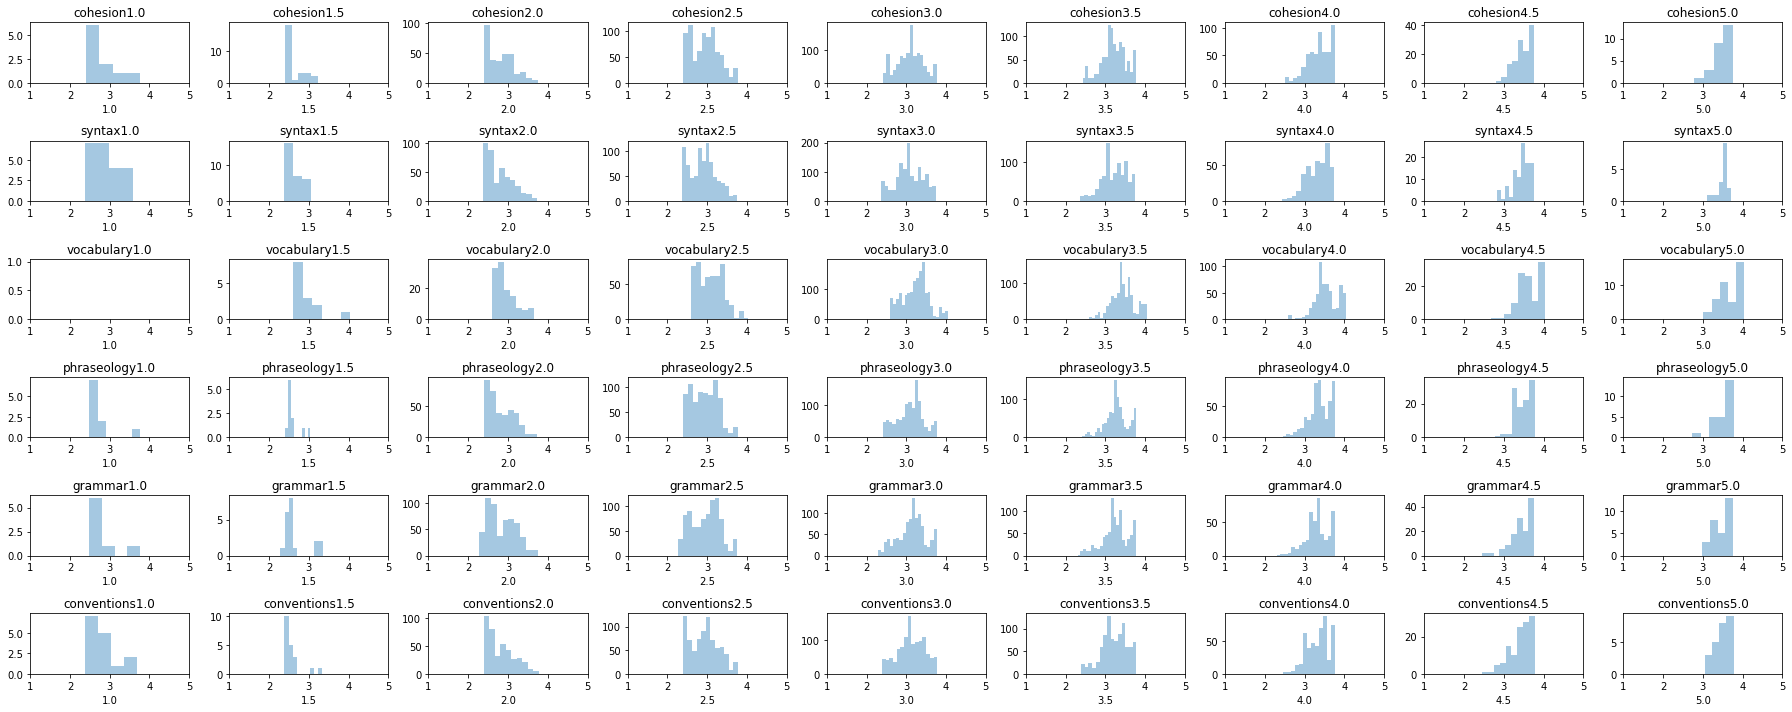

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
count = 1
fig = plt.figure(figsize=(25,10))
for col in cols:
    for score in sorted(y_train[col].unique()):
        ax = fig.add_subplot(6, 9, count)
        print(col, score)
        data = pd.concat([y_train[col], pred[col]], axis=1)
        data.columns = ["true", "pred"]
        sns.distplot(data[data["true"]==score].pred, ax = ax, kde=False);
        ax.set_xlabel(score);
        ax.set_xlim([1,5]);
        ax.set_title(col+str(score));
        plt.tight_layout()
        fig.show();
        count += 1

In [171]:
for col in cols:
    y_train[col].value_counts()
    #sns.displot(y_train[col])

3.0    1096
3.5     988
2.5     790
4.0     534
2.0     315
4.5     125
1.5      27
5.0      26
1.0      10
Name: cohesion, dtype: int64

3.0    1250
3.5     867
2.5     839
2.0     410
4.0     388
4.5     100
1.5      29
5.0      17
1.0      11
Name: syntax, dtype: int64

3.0    1503
3.5    1007
4.0     577
2.5     528
2.0     124
4.5     115
5.0      41
1.5      14
1.0       2
Name: vocabulary, dtype: int64

3.0    1153
3.5     929
2.5     772
4.0     553
2.0     350
4.5     108
5.0      25
1.5      11
1.0      10
Name: phraseology, dtype: int64

3.0    994
3.5    880
2.5    855
2.0    544
4.0    447
4.5    134
5.0     29
1.5     20
1.0      8
Name: grammar, dtype: int64

3.0    1151
3.5     908
2.5     784
4.0     484
2.0     402
4.5     122
5.0      25
1.5      20
1.0      15
Name: conventions, dtype: int64

In [15]:
preds = [keras1_pred, keras2_pred, keras3_pred, keras4_pred, lgb1_pred, lgb2_pred]
pred = pd.DataFrame(np.mean(np.array(preds), axis=0), columns=cols, index=X_test_idx)
pred

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,2.767483,2.733454,2.969960,2.808294,2.716757,2.652545
000BAD50D026,3.038738,2.872625,3.037558,2.952971,2.719184,2.952540
00367BB2546B,3.365481,3.267979,3.486429,3.339178,3.286980,3.294214


In [86]:
pred.to_csv("submission.csv", index=True)